# Import Libraries

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # Prevent incompatible gpu

In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-07-23 22:23:47.724931: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 22:23:48.163279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753280628.335565   13187 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753280628.388879   13187 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753280628.765018   13187 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Exploratory Data Analysis

In [4]:
ROOT = "../../datasets/"
SEED = 88
IMG_SIZE = (224, 224)    # load at original size first
BATCH_SIZE = 256
LABEL_MODE = "categorical" # one‑hot labels straight away

classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

def load_split(split):
    dataset=tf.keras.preprocessing.image_dataset_from_directory(ROOT+split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset

train_ds_pre = load_split("train")
val_ds_pre = load_split("validate")
test_ds_pre = load_split("test")

Found 7004 files belonging to 3 classes.
Found 859 files belonging to 3 classes.
Found 860 files belonging to 3 classes.


2025-07-23 22:23:53.717209: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


,broccoli,cauliflower,unknown,splits total
test,311,299,250,860
train,2595,2407,2002,7004
validate,311,298,250,859
img total,3217,3004,2502,8723


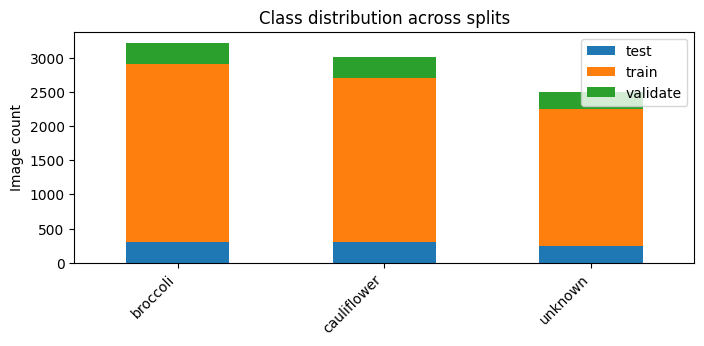

In [5]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

2025-07-23 22:23:55.187013: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


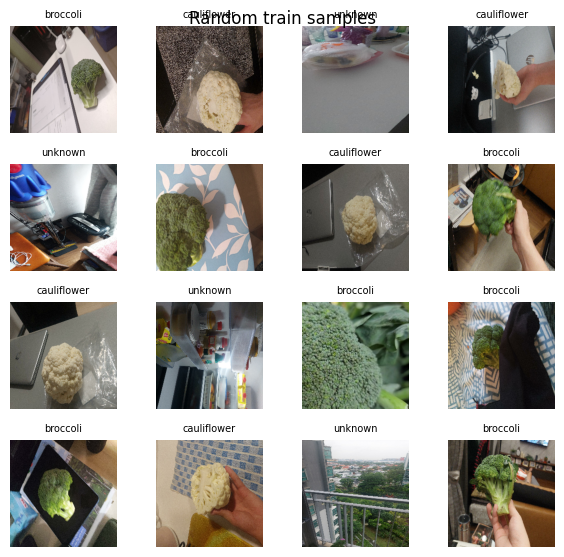

In [6]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [7]:
TARGET_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom((0.3), 0.3),
    layers.RandomBrightness(0.2, value_range=(0, 1)),
    layers.RandomErasing(0.3, value_range=(0, 1))
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)

2025-07-23 22:24:06.140174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 14 of 1000
2025-07-23 22:24:15.426234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 22:24:22.658532: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


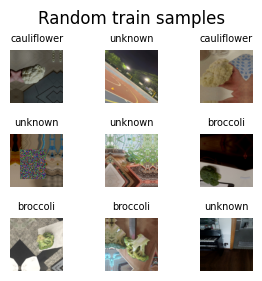

In [8]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [9]:
num_classes = 3

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation="relu",
                 input_shape=(TARGET_SIZE, TARGET_SIZE,3)))

model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))

model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(512, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   
model.add(layers.Dropout(0.3))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))

model.summary()

Optimizer = optimizers.AdamW(0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Optimizer,
              metrics=['accuracy'])


/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,605,763 (6.13 MB)

 Trainable params: 1,605,763 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [11]:
history = model.fit(
    train_ds,
    epochs=100,
    verbose=1,
    validation_data = val_ds,
    callbacks=[early_stop]
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights("model.weights.h5")
model.save("model.hdf5")

Epoch 1/100


2025-07-23 22:24:34.291209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 14 of 1000
2025-07-23 22:24:43.839814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 22:24:48.609546: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - accuracy: 0.3832 - loss: 1.0746 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1099s 38s/step - accuracy: 0.3851 - loss: 1.0732 - val_accuracy: 0.6019 - val_loss: 0.8964
Epoch 2/100


2025-07-23 22:42:52.793981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 13 of 1000
2025-07-23 22:43:03.415270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 22:43:07.910658: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.5099 - loss: 0.9851 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1076s 38s/step - accuracy: 0.5101 - loss: 0.9844 - val_accuracy: 0.6100 - val_loss: 0.8908
Epoch 3/100


2025-07-23 23:00:48.286452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 12 of 1000
2025-07-23 23:00:59.021313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-07-23 23:01:00.734874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 23:01:05.459246: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.5349 - loss: 0.9279 

Invalid SOS parameters for sequential JPEG
2025-07-23 23:19:10.396549: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1131s 39s/step - accuracy: 0.5356 - loss: 0.9274 - val_accuracy: 0.6484 - val_loss: 0.8014
Epoch 4/100


2025-07-23 23:19:39.541462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 14 of 1000
2025-07-23 23:19:48.223898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 23:19:52.779761: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.5770 - loss: 0.8778 

2025-07-23 23:36:27.203936: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1036s 36s/step - accuracy: 0.5777 - loss: 0.8773 - val_accuracy: 0.7218 - val_loss: 0.7307
Epoch 5/100


2025-07-23 23:36:55.598371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 12 of 1000
2025-07-23 23:37:05.959541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 26 of 1000
2025-07-23 23:37:06.854894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 23:37:11.195109: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.6706 - loss: 0.7879 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 23:53:44.489388: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1037s 36s/step - accuracy: 0.6713 - loss: 0.7877 - val_accuracy: 0.7660 - val_loss: 0.6659
Epoch 6/100


2025-07-23 23:54:13.132967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 13 of 1000
2025-07-23 23:54:23.072301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 23:54:27.576078: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.7546 - loss: 0.6855 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 00:11:30.190547: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1067s 37s/step - accuracy: 0.7551 - loss: 0.6846 - val_accuracy: 0.8417 - val_loss: 0.5112
Epoch 7/100


2025-07-24 00:11:59.842592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 12 of 1000
2025-07-24 00:12:09.996037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-07-24 00:12:11.755410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 00:12:16.370226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.7862 - loss: 0.5765 

Invalid SOS parameters for sequential JPEG
2025-07-24 00:29:28.456677: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1078s 37s/step - accuracy: 0.7865 - loss: 0.5756 - val_accuracy: 0.8335 - val_loss: 0.4755
Epoch 8/100


2025-07-24 00:29:57.544281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 11 of 1000
2025-07-24 00:30:09.870411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 00:30:14.637401: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8087 - loss: 0.5249 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 00:46:56.652169: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1048s 36s/step - accuracy: 0.8088 - loss: 0.5242 - val_accuracy: 0.8754 - val_loss: 0.4111
Epoch 9/100


2025-07-24 00:47:25.826503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 13 of 1000
2025-07-24 00:47:36.699737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 00:47:40.854794: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8270 - loss: 0.4605 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 01:04:10.152853: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1034s 36s/step - accuracy: 0.8267 - loss: 0.4612 - val_accuracy: 0.8277 - val_loss: 0.4628
Epoch 10/100


2025-07-24 01:04:39.007314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 12 of 1000
2025-07-24 01:04:48.993304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-07-24 01:04:50.697683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 01:04:55.374563: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.8217 - loss: 0.4839 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 01:21:43.175776: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1053s 37s/step - accuracy: 0.8218 - loss: 0.4830 - val_accuracy: 0.8685 - val_loss: 0.3533
Epoch 11/100


2025-07-24 01:22:12.590021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 14 of 1000
2025-07-24 01:22:22.479394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 01:22:27.095988: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8408 - loss: 0.4073 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 01:39:02.675164: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1040s 36s/step - accuracy: 0.8407 - loss: 0.4074 - val_accuracy: 0.8801 - val_loss: 0.3171
Epoch 12/100


2025-07-24 01:39:32.390142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 4 of 1000
2025-07-24 01:39:44.296646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 10 of 1000
2025-07-24 01:40:03.630746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 21 of 1000
2025-07-24 01:40:14.302838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 01:40:18.239613: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.8588 - loss: 0.3677 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 01:57:22.245582: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1098s 37s/step - accuracy: 0.8587 - loss: 0.3681 - val_accuracy: 0.8522 - val_loss: 0.3743
Epoch 13/100


2025-07-24 01:57:50.921696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 12 of 1000
2025-07-24 01:58:02.374135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 01:58:06.286403: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8482 - loss: 0.3766 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 02:14:29.753009: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1028s 36s/step - accuracy: 0.8478 - loss: 0.3778 - val_accuracy: 0.8917 - val_loss: 0.3271
Epoch 14/100


2025-07-24 02:14:59.004965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 12 of 1000
2025-07-24 02:15:10.992931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 02:15:15.519039: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.8480 - loss: 0.3848 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 02:31:38.884973: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1029s 35s/step - accuracy: 0.8482 - loss: 0.3842 - val_accuracy: 0.8801 - val_loss: 0.3211
Epoch 15/100


2025-07-24 02:32:07.183246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 14 of 1000
2025-07-24 02:32:17.927742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 22 of 1000
2025-07-24 02:32:18.030356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 02:32:22.347601: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8693 - loss: 0.3292 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 02:48:31.807215: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1013s 35s/step - accuracy: 0.8693 - loss: 0.3293 - val_accuracy: 0.9080 - val_loss: 0.2541
Epoch 16/100


2025-07-24 02:49:00.196996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 14 of 1000
2025-07-24 02:49:09.103275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 02:49:12.756881: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.8652 - loss: 0.3418 

2025-07-24 03:05:20.396521: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1008s 35s/step - accuracy: 0.8651 - loss: 0.3420 - val_accuracy: 0.9127 - val_loss: 0.3262
Epoch 17/100


2025-07-24 03:05:48.980511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 14 of 1000
2025-07-24 03:05:58.021140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 03:06:02.506868: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8687 - loss: 0.3458 

Invalid SOS parameters for sequential JPEG
2025-07-24 03:22:24.903065: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-24 03:22:24.953716: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1036s 36s/step - accuracy: 0.8686 - loss: 0.3462 - val_accuracy: 0.8929 - val_loss: 0.3268
Epoch 18/100


2025-07-24 03:23:00.785948: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-24 03:23:05.767122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 3 of 1000
2025-07-24 03:23:16.009085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 6 of 1000
2025-07-24 03:23:36.250553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 18 of 1000
2025-07-24 03:23:46.809869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a w

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8636 - loss: 0.3580 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 03:40:29.663224: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1073s 36s/step - accuracy: 0.8640 - loss: 0.3568 - val_accuracy: 0.9255 - val_loss: 0.2438
Epoch 19/100


2025-07-24 03:40:58.645925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 13 of 1000
2025-07-24 03:41:09.050147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 03:41:13.348828: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8841 - loss: 0.3057 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 03:57:44.104245: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1034s 36s/step - accuracy: 0.8840 - loss: 0.3059 - val_accuracy: 0.9313 - val_loss: 0.2413
Epoch 20/100


2025-07-24 03:58:12.506966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 11 of 1000
2025-07-24 03:58:22.879642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-07-24 03:58:24.461270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 03:58:28.982544: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8833 - loss: 0.3190 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 04:14:48.026672: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1024s 36s/step - accuracy: 0.8833 - loss: 0.3190 - val_accuracy: 0.9360 - val_loss: 0.2239
Epoch 21/100


2025-07-24 04:15:17.417372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 4 of 1000
2025-07-24 04:15:38.500884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 14 of 1000
2025-07-24 04:16:08.999627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 20 of 1000
2025-07-24 04:16:09.262900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 04:16:11.862255: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8972 - loss: 0.2710 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 04:32:52.384212: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 1084s 36s/step - accuracy: 0.8969 - loss: 0.2714 - val_accuracy: 0.9464 - val_loss: 0.1799
Epoch 22/100


2025-07-24 04:33:20.904248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 12 of 1000
2025-07-24 04:33:30.941295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-07-24 04:33:32.581251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 04:33:36.314031: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9006 - loss: 0.2695 

Invalid SOS parameters for sequential JPEG
2025-07-24 04:50:27.506911: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1059s 37s/step - accuracy: 0.9005 - loss: 0.2694 - val_accuracy: 0.9325 - val_loss: 0.2238
Epoch 23/100


2025-07-24 04:51:01.217314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 3 of 1000
2025-07-24 04:51:15.025572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 7 of 1000
2025-07-24 04:51:31.718221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 19 of 1000
2025-07-24 04:51:42.315194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-07-24 04:51:46.645956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 04:51:51.135819: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already cause

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9001 - loss: 0.2629 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 05:08:20.966626: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1069s 36s/step - accuracy: 0.9001 - loss: 0.2629 - val_accuracy: 0.9232 - val_loss: 0.2097
Epoch 24/100


2025-07-24 05:08:49.855922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 13 of 1000
2025-07-24 05:09:01.590596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 05:09:05.283506: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9014 - loss: 0.2667 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 05:25:46.627477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1046s 36s/step - accuracy: 0.9012 - loss: 0.2676 - val_accuracy: 0.9313 - val_loss: 0.2003
Epoch 25/100


2025-07-24 05:26:15.196826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 12 of 1000
2025-07-24 05:26:26.917406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 05:26:31.413913: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9080 - loss: 0.2626 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-24 05:43:09.130607: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1042s 36s/step - accuracy: 0.9077 - loss: 0.2629 - val_accuracy: 0.8999 - val_loss: 0.2473
Epoch 26/100


2025-07-24 05:43:37.672158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 10 of 1000
2025-07-24 05:43:48.692555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 13 of 1000
2025-07-24 05:44:10.390192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 15 of 1000
2025-07-24 05:44:28.571285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 27 of 1000
2025-07-24 05:44:28.573568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-24 05:44:31.443981: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already cau

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9188 - loss: 0.2263 

Invalid SOS parameters for sequential JPEG
2025-07-24 06:01:36.921146: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 1108s 36s/step - accuracy: 0.9187 - loss: 0.2267 - val_accuracy: 0.9115 - val_loss: 0.2698


2025-07-24 06:01:56.883308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Test loss: 0.2089601755142212
Test accuracy: 0.9372093081474304


# Model Evalutation

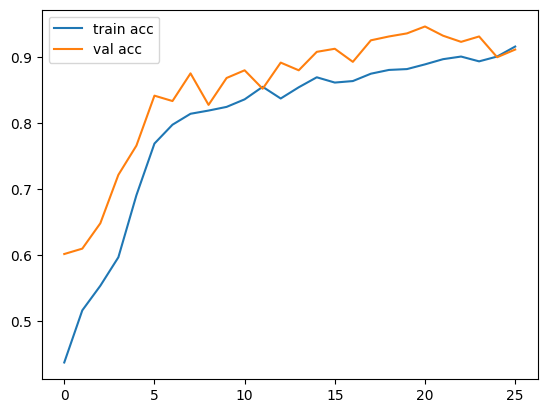

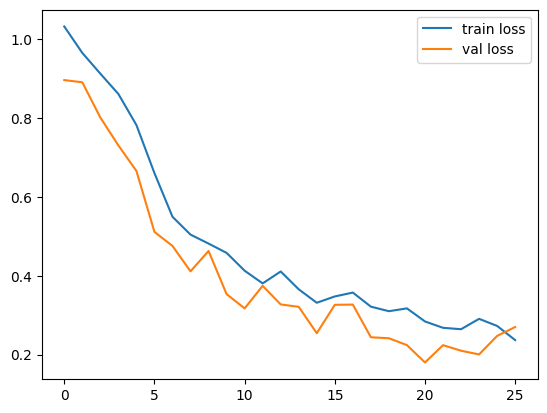

In [14]:
pd.DataFrame(history.history).to_csv("hist.csv", index=False)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

2025-07-24 07:53:06.664784: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154143744 bytes after encountering the first element of size 154143744 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 813ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 702ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 700ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 674ms/step
Broccoli Precision:  0.9485530546623794
Broccoli Recall :  0.9394904458598726

Cauliflower Precision:  0.939799331103679
Cauliflower Recall:  0.9656357388316151

Unknown Precision:  0.92
Unknown Recall:  0.9019607843137255


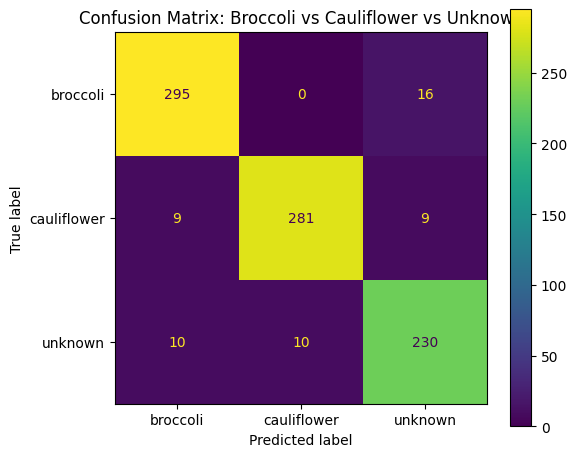

In [16]:
model = tf.keras.models.load_model('./model.hdf5')

y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = np.argmax(tf.concat([item for item in y_true], axis = 0), axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(correct_labels, predicted_labels)
print("Broccoli Precision: ", cm[0][0] / cm[0].sum())
print("Broccoli Recall : ", cm[0][0] / cm.T[0].sum())
print()
print("Cauliflower Precision: ", cm[1][1] / cm[1].sum())
print("Cauliflower Recall: ", cm[1][1] / cm.T[1].sum())
print()
print("Unknown Precision: ", cm[2][2] / cm[2].sum())
print("Unknown Recall: ", cm[2][2] / cm.T[2].sum())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax)
plt.title('Confusion Matrix: Broccoli vs Cauliflower vs Unknown')
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model("model.hdf5") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('gen9Large.tflite', 'wb') as f:
  f.write(tflite_model)

OSError: SavedModel file does not exist at: .//{saved_model.pbtxt|saved_model.pb}